In [1]:
from datetime import datetime
print(datetime.now())
#data preprocessing
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import collections
from collections import defaultdict
# NN
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import math
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, roc_auc_score, auc, accuracy_score
from sklearn.metrics import average_precision_score
import sklearn.metrics as metrics
from sklearn.impute import SimpleImputer
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from matplotlib import pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients

# the full files pathes are here
DATA_PATH_stages="~/data/volume_2/kdigo_stages_measured.csv" 
DATA_PATH_labs = "~/data/volume_2/labs-kdigo_stages_measured.csv" 
DATA_PATH_vitals = "~/data/volume_2/vitals-kdigo_stages_measured.csv" 
DATA_PATH_vents = "~/data/volume_2/vents-vasopressor-sedatives-kdigo_stages_measured.csv"
DATA_PATH_detail="~/data/volume_2/icustay_detail-kdigo_stages_measured.csv" 
SEPARATOR=";"

2023-06-13 20:38:59.443085


In [2]:
IMPUTE_EACH_ID = False # imputation within each icustay_id with most common value
IMPUTE_COLUMN = False # imputation based on whole column

In [3]:
# Set parameter as constant 

TESTING = False 
TEST_SIZE = 0.05

SPLIT_SIZE = 0.2 
MAX_DAYS = 35

#which classifier to use, only run one classifier at one time 
CLASS1 = True   #AnyAKI
#CLASS2 = False    #ModerateSevereAKI
#CLASS3 = False    #SevereAKI
ALL_STAGES = False # not binary label, each class separately 0,1,2,3
    
MAX_FEATURE_SET = True
#DIAGNOSIS = False

FIRST_TURN_POS = True # creating one label per one ICU stay id

# resampling  and imputing
TIME_SAMPLING = True 
SAMPLING_INTERVAL = '6H'
RESAMPLE_LIMIT = 16 # 4 days*6h interval
MOST_COMMON = False #resampling with most common
# if MOST_COMMON is not applied,sampling with different strategies per kind of variable, 
# numeric variables use mean value, categorical variables use max value

IMPUTE_METHOD = 'most_frequent' 
FILL_VALUE = 0 #fill missing value and ragged part of 3d array

#Age constraints: adults
ADULTS_MIN_AGE = 18
ADULTS_MAX_AGE = -1

NORMALIZATION = 'min-max' 

CAPPING_THRESHOLD_UPPER = 0.99
CAPPING_THRESHOLD_LOWER = 0.01

# How much time the prediction should occur (hours)
HOURS_AHEAD = 48

NORM_TYPE = 'min_max'

RANDOM = 42

#set changable info corresponding to each classifier as variables

min_set =  ["icustay_id", "charttime", "creat", "uo_rt_6hr", "uo_rt_12hr", "uo_rt_24hr", "aki_stage"]

max_set = ['icustay_id', 'charttime', 'aki_stage', 'hadm_id','aniongap_avg', 'bicarbonate_avg', 
           'bun_avg','chloride_avg', 'creat', 'diasbp_mean', 'glucose_avg', 'heartrate_mean',
           'hematocrit_avg', 'hemoglobin_avg', 'potassium_avg', 'resprate_mean','sodium_avg', 'spo2_mean', 'sysbp_mean', 
           'uo_rt_12hr', 'uo_rt_24hr','uo_rt_6hr', 'wbc_avg', 'sedative', 'vasopressor', 'vent', 'age', 'F','M', 
           'asian', 'black', 'hispanic', 'native', 'other', 'unknown','white', 'ELECTIVE', 'EMERGENCY', 'URGENT']

# LSTM
batch_size = 5

# naming model and plot
classifier_name = "None vs. Any AKI"    ###change every time #Moderate vs. Severe #None vs. Any #Others vs. Severe
plot_name = "adult_AnyAKI_LR"    ###change every time

In [4]:
# Some functions used later

def cap_data(df):
    print("Capping between the {} and {} quantile".format(CAPPING_THRESHOLD_LOWER, CAPPING_THRESHOLD_UPPER))
    cap_mask = df.columns.difference(['icustay_id', 'charttime', 'aki_stage'])
    df[cap_mask] = df[cap_mask].clip(df[cap_mask].quantile(CAPPING_THRESHOLD_LOWER),
                                     df[cap_mask].quantile(CAPPING_THRESHOLD_UPPER),
                                     axis=1)

    return df
 
    
def normalise_data(df, norm_mask):
    print("Normalizing in [0,1] with {} normalization".format(NORMALIZATION))
    
    df[norm_mask] = (df[norm_mask] - df[norm_mask].min()) / (df[norm_mask].max() - df[norm_mask].min())
    
    return df


# impute missing value in resampleing data with most common based on each id
def fast_mode(df, key_cols, value_col):
    """ Calculate a column mode, by group, ignoring null values. 
    
    key_cols : list of str - Columns to groupby for calculation of mode.
    value_col : str - Column for which to calculate the mode. 

    Return
    pandas.DataFrame
        One row for the mode of value_col per key_cols group. If ties, returns the one which is sorted first. """
    return (df.groupby(key_cols + [value_col]).size() 
              .to_frame('counts').reset_index() 
              .sort_values('counts', ascending=False) 
              .drop_duplicates(subset=key_cols)).drop('counts',axis=1)


#get max shape of 3d array
def get_dimensions(array, level=0):   
    yield level, len(array)
    try:
        for row in array:
            yield from get_dimensions(row, level + 1)
    except TypeError: #not an iterable
        pass

def get_max_shape(array):
    dimensions = defaultdict(int)
    for level, length in get_dimensions(array):
        dimensions[level] = max(dimensions[level], length)
    return [value for _, value in sorted(dimensions.items())]

#pad the ragged 3d array to rectangular shape based on max size
def iterate_nested_array(array, index=()):
    try:
        for idx, row in enumerate(array):
            yield from iterate_nested_array(row, (*index, idx)) 
    except TypeError: # final level            
        yield (*index, slice(len(array))), array # think of the types

def pad(array, fill_value):
    dimensions = get_max_shape(array)
    result = np.full(dimensions, fill_value, dtype = np.float64)  
    for index, value in iterate_nested_array(array):
        result[index] = value 
    return result

def bin_total(y_true, y_prob, n_bins):
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)

    # In sklearn.calibration.calibration_curve,
    # the last value in the array is always 0.
    binids = np.digitize(y_prob, bins) - 1

    return np.bincount(binids, minlength=len(bins))

def missing_bin(bin_array):
    midpoint = " "    
    if bin_array[0]==0:
        midpoint = "5%, "
    if bin_array[1]==0:
        midpoint = midpoint + "15%, "
    if bin_array[2]==0:
        midpoint = midpoint + "25%, "
    if bin_array[3]==0:
        midpoint = midpoint + "35%, " 
    if bin_array[4]==0:
        midpoint = midpoint + "45%, "
    if bin_array[5]==0:
        midpoint = midpoint + "55%, "
    if bin_array[6]==0:
        midpoint = midpoint + "65%, "
    if bin_array[7]==0:
        midpoint = midpoint + "75%, "
    if bin_array[8]==0:
        midpoint = midpoint + "85%, "
    if bin_array[9]==0:
        midpoint = midpoint + "95%, "
    return "The missing bins have midpoint values of "+ str(midpoint)


In [5]:
print("read csv files")
#reading csv files
X = pd.read_csv(DATA_PATH_stages, sep= SEPARATOR)
X.drop(["aki_stage_creat", "aki_stage_uo"], axis = 1, inplace = True)
#remove totally empty rows 
X = X.dropna(how = 'all', subset = ['creat','uo_rt_6hr','uo_rt_12hr','uo_rt_24hr','aki_stage'])
print("convert charttime to timestamp")
X['charttime'] = pd.to_datetime(X['charttime'])

#merge rows if they have exact timestamp within same icustay_id AL : it substitutes missing values with zero
#X = X.groupby(['icustay_id', 'charttime']).sum().reset_index(['icustay_id', 'charttime'])

dataset_detail = pd.read_csv(DATA_PATH_detail, sep= SEPARATOR)  #age constraint
dataset_detail.drop(['dod', 'admittime','dischtime', 'los_hospital','ethnicity','hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'intime', 'outtime', 'los_icu', 'icustay_seq','first_icu_stay'], axis = 1, inplace = True)


read csv files
convert charttime to timestamp


In [6]:
dataset_labs = pd.read_csv(DATA_PATH_labs, sep= SEPARATOR) # 'bands lactate platelet ptt inr pt
dataset_labs.drop(['albumin_min', 'albumin_max','bilirubin_min', 'bilirubin_max','bands_min', 'bands_max',
                   'lactate_min', 'lactate_max','platelet_min', 'platelet_max','ptt_min', 'ptt_max', 
                   'inr_min', 'inr_max', 'pt_min', 'pt_max'], axis = 1, inplace = True)
dataset_labs = dataset_labs.dropna(subset=['charttime'])
dataset_labs = dataset_labs.dropna(subset=dataset_labs.columns[4:], how='all')
dataset_labs['charttime'] = pd.to_datetime(dataset_labs['charttime'])
dataset_labs = dataset_labs.sort_values(by=['icustay_id', 'charttime'])

if  MAX_FEATURE_SET:
    dataset_vitals = pd.read_csv(DATA_PATH_vitals, sep= SEPARATOR)  
    dataset_vents = pd.read_csv(DATA_PATH_vents , sep= SEPARATOR)
    #dataset_icd = pd.read_csv(DATA_PATH_icd, sep= SEPARATOR)
    dataset_vitals.drop(["heartrate_min", "heartrate_max","sysbp_min", "sysbp_max","diasbp_min", "diasbp_max",
                        'meanbp_min','meanbp_max', 'meanbp_mean','tempc_min', 'tempc_max', 'tempc_mean',
                        "resprate_min", "resprate_max", "spo2_min", "spo2_max", "glucose_min", "glucose_max"], axis = 1, inplace = True)    
    print("convert charttime to timestamp")
    dataset_vitals['charttime'] = pd.to_datetime(dataset_vitals['charttime'])
    dataset_vents['charttime'] = pd.to_datetime(dataset_vents['charttime'])
    dataset_vitals = dataset_vitals.sort_values(by=['icustay_id', 'charttime'])
    dataset_vents = dataset_vents.sort_values(by=['icustay_id', 'charttime'])
    # AL drop those where all columns are nan (empty rows)
    dataset_vitals = dataset_vitals.dropna(subset=dataset_vitals.columns[4:], how='all')   
     

convert charttime to timestamp


In [7]:
print(datetime.now())
# Labs file: instead of min and max their avg
counter = 0
col1 = 4
col2 = 5
null_l = [] # no null values in those that are different
changed = 0 # 4316 records changed to avg

while counter < 11:
    row = 0
# find where min and max are different and save their row indices 
    while row < len(dataset_labs):
        a = dataset_labs.iloc[row,col1]
        b = dataset_labs.iloc[row,col2]
        if a==b or (np.isnan(a) and np.isnan(b)):
            pass
        elif a!=b:
            changed +=1
            avg = (a+b)/2
            dataset_labs.iloc[row,col1] = avg
            if (np.isnan(a) and ~np.isnan(b)) or (np.isnan(b) and ~np.isnan(a)):
                null_l.append(row)
        else:
            print(a)
            print(b)
        row +=1       
    # delete the redundant column max, update counters
    dataset_labs.drop(dataset_labs.columns[col2], axis=1, inplace = True)
    counter = counter+1
    col1 = col1+1
    col2 = col2+1

dataset_labs.columns = ['subject_id','hadm_id', 'icustay_id', 'charttime', 'aniongap_avg', 'bicarbonate_avg', 
                        'creatinine_avg', 'chloride_avg', 'glucose_avg', 'hematocrit_avg','hemoglobin_avg',
                        'potassium_avg', 'sodium_avg', 'bun_avg', 'wbc_avg']
if len(null_l)>0:
    print("null values encountered")
print(datetime.now())

2023-06-13 20:40:08.662927
2023-06-13 20:49:44.412561


In [8]:
print("Merge creatinine and glucose.")
# merge creatinine from labs and set with labels
creat_l = dataset_labs[['icustay_id','charttime','creatinine_avg']].copy()
creat_l = creat_l.dropna(subset=['creatinine_avg'])
creat = X[['icustay_id','charttime', 'creat']].copy()
creat = creat.dropna(subset=['creat'])
creat_l = creat_l.rename(columns={"creatinine_avg": "creat"})
creat = creat.append(creat_l, ignore_index=True)
creat.drop_duplicates(inplace = True)
#delete old columns
dataset_labs.drop(["creatinine_avg"], axis = 1, inplace = True)
dataset_labs = dataset_labs.dropna(subset=dataset_labs.columns[4:], how='all')
X.drop(["creat"], axis = 1, inplace = True)
#merge new column
X = pd.merge(X, creat, on = ["icustay_id", "charttime"], sort = True, how= "outer", copy = False)

if MAX_FEATURE_SET:
    # merge glucose from vitals and labs
    glucose_v = dataset_vitals[['subject_id','hadm_id','icustay_id','charttime', 'glucose_mean']].copy()
    glucose_v = glucose_v.dropna(subset=['glucose_mean'])
    glucose = dataset_labs[['subject_id','hadm_id','icustay_id','charttime', 'glucose_avg']].copy()
    glucose = glucose.dropna(subset=['glucose_avg'])
    glucose_v = glucose_v.rename(columns={"glucose_mean": "glucose_avg"})
    glucose = glucose.append(glucose_v, ignore_index=True)
    glucose.drop_duplicates(inplace = True)
    #delete old columns
    dataset_labs.drop(["glucose_avg"], axis = 1, inplace = True)
    dataset_vitals.drop(["glucose_mean"], axis = 1, inplace = True)
    dataset_vitals = dataset_vitals.dropna(subset=dataset_vitals.columns[4:], how='all')
    #merge new column
    dataset_labs = pd.merge(dataset_labs, glucose, on = ['subject_id','hadm_id','icustay_id','charttime',], sort = True, how= "outer", copy = False)
    
dataset_labs = dataset_labs.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)

Merge creatinine and glucose.


In [9]:
print("Merging labs, vitals and vents files")
if MAX_FEATURE_SET:
    X = pd.merge(X, dataset_labs, on = ["icustay_id", "charttime"], how= "outer", copy = False)
    X = pd.merge(X, dataset_vitals, on = ["icustay_id", "charttime","subject_id", "hadm_id"], how= "outer", copy = False)
    X = pd.merge(X, dataset_vents, on = ["icustay_id", "charttime"], how= "outer", copy = False) 
    X.drop(["subject_id"], axis = 1, inplace = True) 


Merging labs, vitals and vents files


In [12]:
print("start preprocessing time dependent data") 
print("Removing patients under the min age")
dataset_detail = dataset_detail.loc[dataset_detail['age'] >= ADULTS_MIN_AGE]
adults_icustay_id_list = dataset_detail['icustay_id'].unique()
X = X[X.icustay_id.isin(adults_icustay_id_list)].sort_values(by=['icustay_id'], ignore_index = True)
X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
adults_icustay_id_list = np.sort(adults_icustay_id_list)

start preprocessing time dependent data
Removing patients under the min age


In [14]:
print("drop icustay_id with time span less than 48hrs")
def more_than_HOURS_ahead(adults_icustay_id_list, X):
    drop_list = []
    los_list = [] # calculating LOS ICU based on charttime
    long_stays_id = [] # LOS longer than MAX DAYS days
    last_charttime_list = []
    seq_length = X.groupby(['icustay_id'],as_index=False).size()
    id_count = 0
    first_row_index = 0

    while id_count < len(adults_icustay_id_list):
        icustay_id = adults_icustay_id_list[id_count]
        last_row_index = first_row_index + seq_length.iloc[id_count,1]-1
        first_time = X.iat[first_row_index, X.columns.get_loc('charttime')]
        last_time = X.iat[last_row_index, X.columns.get_loc('charttime')]
        los = round(float((last_time - first_time).total_seconds()/60/60/24),4) # in days
        if los < HOURS_AHEAD/24:
            drop_list.append(icustay_id)
        else:
            los_list.append(los)
            if los > MAX_DAYS:
                long_stays_id.append(icustay_id)
                last_charttime_list.append(last_time)
        # udpate for the next icustay_id
        first_row_index = last_row_index+1
        id_count +=1
    if len(long_stays_id) != len(last_charttime_list):
        print('ERROR')
    print("%d long stays" % len(long_stays_id))
    # drop all the rows with the saved icustay_id
    print("there are %d id-s shorter than 48 hours" % len(drop_list))
    X = X[~X.icustay_id.isin(drop_list)]
    id_list = X['icustay_id'].unique()
    X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
    
    return id_list, X, long_stays_id,last_charttime_list

id_list, X, long_stays_id,last_charttime_list  = more_than_HOURS_ahead(adults_icustay_id_list, X)

long = pd.DataFrame()
long['icustay_id']  = long_stays_id
long['last_time']  = last_charttime_list

drop icustay_id with time span less than 48hrs
2302 long stays
there are 5214 id-s shorter than 48 hours


In [15]:
# deleting rows that are not within MAX_DAYS (35) period
i = 0 # long df index
drop_long_time = []
    
while i < len(long_stays_id):
    j = 0
    all_rows = X.index[X['icustay_id'] == long.loc[i,'icustay_id']].tolist()
    while j < len(all_rows):
        time = X.iat[all_rows[j], X.columns.get_loc('charttime')]
        # if keep last MAX_DAYS 
        if (long.loc[i,'last_time'] - time).total_seconds() > MAX_DAYS*24*60*60:
            drop_long_time.append(all_rows[j])
            j +=1
        else:
            break
    i +=1       
X.drop(X.index[drop_long_time], inplace=True) 

# checking for 48h min length again
id_list, X, long_stays_id,last_charttime_list  = more_than_HOURS_ahead(id_list, X)
dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'], ignore_index = True)


0 long stays
there are 1 id-s shorter than 48 hours


In [16]:
''' # if you ever use ICD table you need this to merge things right
if  MAX_FEATURE_SET:
    # AL create a dictionary for hadm
    hadm = dataset_detail.filter(['hadm_id','icustay_id'],axis = 1)
    dict_hadm = pd.Series(hadm.hadm_id.values,index=hadm.icustay_id).to_dict()
    # fill in the missing values (to ensure correct merging of icd below)
    X.hadm_id = X.hadm_id.fillna(FILL_VALUE)
    # AL change the type to prevent warning of merging int on float
    X = X.astype({"hadm_id": int})
    a = -1
    while a < X.shape[0]-1:
        a = a+1
        if X.iat[a, X.columns.get_loc('hadm_id')] !=-1 :
            continue
        elif X.iat[a, X.columns.get_loc('hadm_id')]==-1:
            X.iat[a, X.columns.get_loc('hadm_id')] = dict_hadm[X.iat[a, X.columns.get_loc('icustay_id')]]
'''

' # if you ever use ICD table you need this to merge things right\nif  MAX_FEATURE_SET:\n    # AL create a dictionary for hadm\n    hadm = dataset_detail.filter([\'hadm_id\',\'icustay_id\'],axis = 1)\n    dict_hadm = pd.Series(hadm.hadm_id.values,index=hadm.icustay_id).to_dict()\n    # fill in the missing values (to ensure correct merging of icd below)\n    X.hadm_id = X.hadm_id.fillna(FILL_VALUE)\n    # AL change the type to prevent warning of merging int on float\n    X = X.astype({"hadm_id": int})\n    a = -1\n    while a < X.shape[0]-1:\n        a = a+1\n        if X.iat[a, X.columns.get_loc(\'hadm_id\')] !=-1 :\n            continue\n        elif X.iat[a, X.columns.get_loc(\'hadm_id\')]==-1:\n            X.iat[a, X.columns.get_loc(\'hadm_id\')] = dict_hadm[X.iat[a, X.columns.get_loc(\'icustay_id\')]]\n'

# For testing purpose, use small amount of data first

In [17]:
if TESTING:
    rest, id_list = train_test_split(id_list, test_size= TEST_SIZE, random_state=42)
    X = X[X.icustay_id.isin(id_list)].sort_values(by=['icustay_id'])
    dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'])

# Resampling , imputing

In [18]:
if (TIME_SAMPLING and MOST_COMMON):
    print("resampling: MOST_COMMON")
    # Resample the data using assigned interval,mode() for most common
    X = X.set_index('charttime').groupby('icustay_id').resample(SAMPLING_INTERVAL).mode().reset_index()
elif TIME_SAMPLING:
    print("resampling: MEAN & ZERO")
    # Sampling with different strategies per kind of variable
    label = ['aki_stage']
    skip = ['icustay_id', 'charttime', 'aki_stage']
    if MAX_FEATURE_SET:
        discrete_feat = ['sedative', 'vasopressor', 'vent', 'hadm_id']
        skip.extend(discrete_feat)    
    # all features that are not in skip are numeric
    numeric_feat = list(X.columns.difference(skip))
    
    # Applying aggregation to features depending on their type
    X = X.set_index('charttime').groupby('icustay_id').resample(SAMPLING_INTERVAL)
    if MAX_FEATURE_SET:
        X_discrete = X[discrete_feat].max().fillna(FILL_VALUE).astype(np.int64)
    X_numeric = X[numeric_feat].mean() 
    X_label = X['aki_stage'].max()
    print("Merging sampled features")
    try:
        X = pd.concat([X_numeric, X_discrete,X_label], axis=1).reset_index()
    except:
        X = pd.concat([X_numeric,X_label], axis=1).reset_index()
print(X.shape)
#Label forward fill
X['aki_stage'] = X['aki_stage'].ffill(limit=RESAMPLE_LIMIT)

resampling: MEAN & ZERO
Merging sampled features
(2156523, 26)


In [19]:
print("Imputation.")
# do imputation of label with zero if there are still missing values
X['aki_stage'] = X['aki_stage'].fillna(0)

# using most common within each icustay_id
if IMPUTE_EACH_ID:
    column_name = list(X.columns)
    column_name.remove(column_name[0]) 
    for feature in column_name:
        X.loc[X[feature].isnull(), feature] = X.icustay_id.map(fast_mode(X, ['icustay_id'], feature).set_index('icustay_id')[feature])       

# imputation based on whole column
if IMPUTE_COLUMN:
    imp = SimpleImputer(missing_values=np.nan, strategy= IMPUTE_METHOD)
    cols = list(X.columns)
    cols = cols[2:23]
    X[cols]=imp.fit_transform(X[cols])  

# If no imputation method selected or only impute each id, for the remaining nan impute direclty with FILL_VALUE
X = X.fillna(FILL_VALUE) 

Imputation.


In [20]:
# more comfortable to review in this order
try:
    cols = ['icustay_id', 'charttime','aki_stage','hadm_id','aniongap_avg','bicarbonate_avg', 'bun_avg','chloride_avg',
            'creat','diasbp_mean', 'glucose_avg', 'heartrate_mean', 'hematocrit_avg','hemoglobin_avg', 
            'potassium_avg', 'resprate_mean', 'sodium_avg','spo2_mean', 'sysbp_mean', 'uo_rt_12hr', 
            'uo_rt_24hr', 'uo_rt_6hr','wbc_avg', 'sedative', 'vasopressor', 'vent' ]
    X = X[cols]
    print("success")
except:
    try:
        cols = ['icustay_id', 'charttime','aki_stage','creat','uo_rt_12hr', 'uo_rt_24hr', 'uo_rt_6hr']
        X = X[cols]
    except:
        print("error")

success


In [21]:
print("binarise labels")
if ALL_STAGES:
    pass
elif CLASS1:
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS2:
    X.loc[X['aki_stage'] < 2, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS3:
    X.loc[X['aki_stage'] < 3, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 2, 'aki_stage'] = 1

binarise labels


# SHIFTING labels

In [22]:
#print("Shifting the labels 48 h") # by 8 position : 6h sampling*8=48h and ffil 8 newly empty ones
X['aki_stage'] = X.groupby('icustay_id')['aki_stage'].shift(-(HOURS_AHEAD // int(SAMPLING_INTERVAL[:-1])))
X = X.dropna(subset=['aki_stage'])
X['icustay_id'].nunique()

47751

# Add categorical features (details)

In [23]:
print(dataset_detail.columns)

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'age',
       'ethnicity_grouped', 'admission_type'],
      dtype='object')


In [ ]:
print("start preprocessing not time dependent data")
if MAX_FEATURE_SET:
    #extract datasets based on id_list
    dataset_detail = dataset_detail.loc[dataset_detail['icustay_id'].isin(id_list)]
    #sort by ascending order
    dataset_detail = dataset_detail.sort_values(by=['icustay_id'])
    subject_id = dataset_detail["subject_id"].unique()
    #transfrom categorical data to binary form
    dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop('gender')))
    dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop("ethnicity_grouped")))
    dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop('admission_type')))
    dataset_detail = dataset_detail.drop(['subject_id', 'hadm_id'], axis=1)
    X =  pd.merge(X, dataset_detail, on = ["icustay_id"], how= "left", copy = False) 
    numeric_feat.append('age')

In [37]:
feature_names =['Anion gap', 'Bicarbonate', 'Blood Urea Nitrogen', 'Chloride', 'Creatinine', 'Diastolic BP', 'Glucose', 'Heart rate', 
            'Hematocrit', 'Hemoglobin', 'Potassium', 'Respiratory rate', 'Sodium', 'Oxygen saturation', 'Systolic BP', 'Urine output 12h', 'Urine output 24h', 'Urine output 6h',
            'White cell count', 'Sedative', 'Vasopressor', 'Ventilation', 'Age', 'Female gender', 'Male gender', 'Asian ethnicity', 'Black ethnicity', 'Hispanic ethnicity', 'Native american', 
            'Other ethnicity', 'Ethnicity unknown', 'White ethnicity', 'Elective admission', 'Emergency admission', 'Urgent admission']



#  Cap features between 0.01 / 0.99 quantile and normalisation

In [38]:
X = cap_data(X)

X = normalise_data(X, numeric_feat)

Capping between the 0.01 and 0.99 quantile
Normalizing in [0,1] with min-max normalization


In [39]:
X = X.sort_values(by=['icustay_id', 'charttime'])
seq_lengths = X.groupby(['icustay_id'],as_index=False).size().sort_values(by = ['size'],ascending=False)
sequence_length = seq_lengths.max() # the longest sequence per icustay-id
print(sequence_length)

icustay_id    299999
size             133
dtype: int64


In [40]:
#AL re-write as try except to make it work as hadm_id is not used if only one csv file is used and none are merged
try:
    X.drop(['hadm_id'], axis=1, inplace = True)
except:
    pass

In [41]:
features = X.shape[1]-3

In [42]:
print("divide dataset into train, test and validation sets")
id_train, id_test_val = train_test_split(id_list, test_size = SPLIT_SIZE, random_state = 42) # train set is 80%)
print("train is %d" % len(id_train))
# remaining 20% split in halves as test and validation 10% and 10%
id_valid, id_test = train_test_split(id_test_val, test_size = 0.5, random_state = 42) # test 10% valid 10%
print("val and test are %d" %len(id_test))


divide dataset into train, test and validation sets
train is 38200
val and test are 4776


In [43]:
train = X[X.icustay_id.isin(id_train)].sort_values(by=['icustay_id'])
test = X[X.icustay_id.isin(id_test)].sort_values(by=['icustay_id'], ignore_index = True) 
validation = X[X.icustay_id.isin(id_valid)].sort_values(by=['icustay_id']) 

test = test.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
train = train.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
validation = validation.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)

In [44]:
test.shape

(174987, 38)

In [45]:
test['icustay_id'].nunique()

4776

In [46]:
test_seq = test.groupby(['icustay_id'],as_index=False).size()

# remember 1 label per icu stay for the test set (modified)

In [ ]:
Z = test.copy(deep = True) #deep = True
test = test.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
id_test.sort()
#last_charttime_list= []

index_list = []
label_list = []
timestamp_each = []

first_row_index = 0
id_count = 0
seq_length = Z.groupby(['icustay_id'],as_index=False).size()

for ID in id_test:
    last_row_index = first_row_index + seq_length.iloc[id_count]-1
    a = Z.loc[Z['icustay_id']==ID].aki_stage
    if 1 not in a.values:
        label_list.append(0)
        #last_charttime_list.append(Z.iat[last_row_index, Z.columns.get_loc('charttime')]) 
        index_list.append(last_row_index)
        timestamp_each.append(last_row_index-first_row_index)
    elif 1 in a.values:
        label_list.append(1)
        row = first_row_index
        while row != last_row_index+1:
            if Z.iat[row, Z.columns.get_loc('aki_stage')]==0:
                row +=1
            elif Z.iat[row, Z.columns.get_loc('aki_stage')]==1:
                #last_charttime_list.append(Z.iat[row, Z.columns.get_loc('charttime')])
                index_list.append(row)
                break
        timestamp_each.append(row-first_row_index)
    first_row_index = last_row_index+1
    id_count +=1

print(len(timestamp_each))

In [ ]:
max(timestamp_each)

In [ ]:
test.drop(['charttime'], axis=1, inplace = True)
train.drop(['charttime'], axis=1, inplace = True)
validation.drop(['charttime'], axis=1, inplace = True)

In [ ]:
np.version.version

In [ ]:
#print("reshape 2D dataframe to 3D Array, group by icustay_id")
train = np.array(sorted(list(train.groupby(['icustay_id'],as_index=False).apply(pd.DataFrame.to_numpy)),key=len, reverse=True))
test = np.array(list(test.groupby(['icustay_id'],as_index=False).apply(pd.DataFrame.to_numpy)))
validation = np.array(list(validation.groupby(['icustay_id'],as_index=False).apply(pd.DataFrame.to_numpy)))

print(train.shape)

In [ ]:
print(test.shape)

In [ ]:
print(validation.shape)

In [ ]:
print(train.shape)

# LSTM

In [ ]:
if (torch.cuda.is_available()):
    print('Training on GPU')
else:
    print('Training on CPU') # On mac book GPU is not possible =() 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [ ]:
def batch(data, batch_size):
    X_batches = []
    y_batches = []
    times = math.floor(data.shape[0]/batch_size)
    remainder = data.shape[0]%times
    a = 0
    start = 0
    end = start+batch_size
    if remainder ==0:
        a +=1
    while a<times:
        temp = pad(data[start:end,],0)
        x = torch.from_numpy(temp[:,:,2:]).float() # without icustay_id and without aki_stage columns
        y = torch.flatten(torch.from_numpy(temp[:, :,1].reshape(-1,1)).float()).long()
        X_batches.append(x)
        y_batches.append(y)
        start = end
        end = start+batch_size
        a +=1
    temp = pad(data[start:data.shape[0]],0)
    x = torch.from_numpy(temp[:,:,2:]).float()
    y = torch.flatten(torch.from_numpy(temp[:, :,1].reshape(-1,1)).float()).long()
    X_batches.append(x)
    y_batches.append(y)
    if len(X_batches) != len(y_batches):
        print("length error")
    return X_batches, y_batches # arrays

# batching
X_train, y_train = batch(train, batch_size) # batch_size # to count weights

# counting balance of the classes
y = []
for i in y_train:
    for element in i:
        y.append(element.item())

#  weights
counter=collections.Counter(y)
print(counter)
zeroes = counter[0]
ones = counter[1]

X_test, y_test = batch(test, test.shape[0]) 
X_val, y_val = batch(validation, validation.shape[0])
X_val = X_val[0]
y_val = y_val[0]
X_test = X_test[0]
y_test = y_test[0]
print(y_test.shape)


In [ ]:
#####################
# setup

bi_directional = True
n_epochs = 20
lr = 0.001
emb_size = round(features/1)
number_layers = 3
dropout = 0 # dropout

##########################
input_size = features
output_size = 1

In [ ]:
# previous model
class Net(nn.Module):
    def __init__(self, input_size, emb_size, output_size, bi_directional, number_layers, dropout):
        super(Net, self).__init__()
        self.input_size = input_size
        self.emb_size = emb_size 
        self.output_size = output_size
        self.number_layers = number_layers
        self.fc1 = nn.Linear(self.input_size, self.emb_size, bias = True) # I can have a few (IV) within this line - documentation        
        self.fc2 = nn.LSTM(self.emb_size, self.output_size,num_layers=self.number_layers, batch_first = True, bidirectional = bi_directional) 
        # in bidirectional encoder we have  forward and backward hidden states
        self.encoding_size = self.output_size * 2 if bi_directional else self.output_size
        self.combination_layer = nn.Linear(self.encoding_size, self.encoding_size)
        # Create affine layer to project to the classes 
        self.projection = nn.Linear(self.encoding_size, self.output_size)
        #dropout layer for regularizetion of a sequence
        self.dropout_layer = nn.Dropout(p = dropout)  
        self.relu = nn.ReLU()

        
    def forward(self, x):
        h = self.relu(self.fc1(x))
        h, _ = self.fc2(h) # h, _ : as I have 2outputs (tuple), only take the real output [0]. 
        #print(type(h)) # Underscore throughs away the rest, _ "I do not care" variable notation in python
        h = self.relu(self.combination_layer(h))
        h = self.dropout_layer(h)
        h = self.projection(h) 
        return h

#create a network 
nn_model = Net(input_size, emb_size, output_size,bi_directional, number_layers, dropout)
#print(nn_model)
#print(list(nn_model.parameters()))


# BCE Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(round(zeroes/ones,0))) # class imbalance
#print(round(zeroes/ones,0))
optimizer = optim.Adam(nn_model.parameters(), lr=lr) 
    

In [ ]:
class new_Net(nn.Module):
    def __init__(self, input_size, emb_size, output_size, bi_directional, number_layers, dropout):
        super(new_Net, self).__init__()
        self.input_size = input_size
        self.emb_size = emb_size 
        self.output_size = output_size
        self.number_layers = number_layers
        self.encoding_size = self.output_size * 2 if bi_directional else self.output_size
                
        self.layer1 = nn.Sequential(
            nn.Linear(self.input_size, self.emb_size, bias = True),
            nn.ELU(),
            nn.LSTM(self.emb_size, self.output_size,num_layers=self.number_layers, batch_first = True, bidirectional = bi_directional))
        self.layer2 = nn.Sequential(
            nn.Linear(self.encoding_size, 1),
            nn.ELU(),
            nn.Dropout(p = dropout),
            nn.Linear(1, self.output_size)
        )
        
    def forward(self,x):
        h, _ = self.layer1(x)  # Select only the output tensor from the LSTM layer tuple
        h = self.layer2(h)  # Pass the output tensor to the last three layers in the sequential layer
        return h

#create a new network 
nn_model_new = new_Net(input_size, emb_size, output_size,bi_directional, number_layers, dropout)

# BCE Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(round(zeroes/ones,0))) # class imbalance
#print(round(zeroes/ones,0))
optimizer = optim.Adam(nn_model_new.parameters(), lr=lr) 

In [ ]:
# training loop previous (full data 3.5 hours)

epochs = 3
starttime = datetime.now() # datetime object containing current date and time
train_losses, validation_losses = [], []
best = 0
best_epoch_index = 0
print("starttime =", starttime)

for epoch in range(epochs):  # loop over the dataset multiple times
    print ("\n Epoch [%d] out of %d" % (epoch + 1, epochs))
    running_loss = 0.0
    validation_loss = 0.0
    roc_auc = 0.0
    pr_auc = 0.0
    m = 0
    
    #train
    #print(list(nn_model.parameters())[0])
    for i in X_train:
        # zero the parameter gradients
        optimizer.zero_grad() # zero the gradient buffers not to consider gradients of previous iterations
        X_batch = X_train[m]
        y_batch = y_train[m]
        # forward + backward + optimize
        outputs = nn_model(X_batch)
        outputs = torch.flatten(outputs)
        y_batch = y_batch.type_as(outputs)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step() # Does the update
        running_loss += loss.item()
        m +=1
        
   
        #validation 
    nn_model.eval()
    with torch.no_grad():
        v_out = nn_model(X_val) 
        v_out = torch.flatten(v_out) 
        y_val = y_val.type_as(v_out)
        v_loss = criterion(v_out, y_val)
        validation_loss = v_loss.item()
        # auc and pr auc
        val_prob = torch.nn.Sigmoid() (v_out)
        roc_auc = roc_auc_score(y_val,val_prob) 
        
    validation_losses.append(validation_loss) 
    train_losses.append(running_loss/len(X_train)) 
    print(f"Training loss: {running_loss/len(X_train):.3f}.. " f"Validation loss: {validation_loss:.3f}.. ")
    print(f"AUC: {roc_auc:.2f}")  
    nn_model.train()
    
    
    if roc_auc > best:
        best = roc_auc
        PATH = './LSTMbest2.pth' 
        torch.save(nn_model.state_dict(), PATH) # save the model
        best_epoch_index = epoch
        print("best epoch index = " + str(best_epoch_index))
    else:
        pass
    
       
print('Finished Training')
print("starttime =", starttime)
now = datetime.now()
print("now =", now)
print(best_epoch_index)

In [59]:
# training loop NEW

epochs = 80
starttime = datetime.now() # datetime object containing current date and time
train_losses, validation_losses = [], []
best = 0
best_epoch_index = 0
print("starttime =", starttime)

for epoch in range(epochs):  # loop over the dataset multiple times
    print ("\n Epoch [%d] out of %d" % (epoch + 1, epochs))
    running_loss = 0.0
    validation_loss = 0.0
    roc_auc = 0.0
    pr_auc = 0.0
    m = 0
    
    
    #train
    #print(list(nn_model.parameters())[0])
    for i in X_train:
        # zero the parameter gradients
        optimizer.zero_grad() # zero the gradient buffers not to consider gradients of previous iterations
        X_batch = X_train[m]
        y_batch = y_train[m]
        # forward + backward + optimize
        outputs = nn_model_new(X_batch)
        outputs = torch.flatten(outputs)
        y_batch = y_batch.type_as(outputs)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step() # Does the update
        running_loss += loss.item()
        m +=1
        
   
        #validation 
    nn_model_new.eval()
    with torch.no_grad():
        v_out = nn_model_new(X_val) 
        v_out = torch.flatten(v_out) 
        y_val = y_val.type_as(v_out)
        v_loss = criterion(v_out, y_val)
        validation_loss = v_loss.item()
        # auc and pr auc
        val_prob = torch.nn.Sigmoid() (v_out)
        roc_auc = roc_auc_score(y_val,val_prob) 
        
    validation_losses.append(validation_loss) 
    train_losses.append(running_loss/len(X_train)) 
    print(f"Training loss: {running_loss/len(X_train):.3f}.. " f"Validation loss: {validation_loss:.3f}.. ")
    print(f"AUC: {roc_auc:.2f}")  
    nn_model_new.train()
    
    
    if roc_auc > best:
        best = roc_auc
        PATH_NEW = './LSTM_new.pth' 
        torch.save(nn_model_new.state_dict(), PATH_NEW)# save the model
        best_epoch_index = epoch
        print("best epoch index = " + str(best_epoch_index))
    else:
        pass
    
       
print('Finished Training')
print("starttime =", starttime)
now = datetime.now()
print("now =", now)
print(best_epoch_index)

# new = 0.91

starttime = 2023-05-03 12:06:53.635105

 Epoch [1] out of 80
Training loss: 1.048.. Validation loss: 0.663.. 
AUC: 0.83
best epoch index = 0

 Epoch [2] out of 80
Training loss: 0.977.. Validation loss: 0.713.. 
AUC: 0.79

 Epoch [3] out of 80
Training loss: 0.949.. Validation loss: 0.541.. 
AUC: 0.86
best epoch index = 2

 Epoch [4] out of 80
Training loss: 0.933.. Validation loss: 0.473.. 
AUC: 0.91
best epoch index = 3

 Epoch [5] out of 80
Training loss: 0.925.. Validation loss: 0.446.. 
AUC: 0.92
best epoch index = 4

 Epoch [6] out of 80
Training loss: 0.920.. Validation loss: 0.439.. 
AUC: 0.92

 Epoch [7] out of 80
Training loss: 0.917.. Validation loss: 0.441.. 
AUC: 0.91

 Epoch [8] out of 80
Training loss: 0.915.. Validation loss: 0.444.. 
AUC: 0.90

 Epoch [9] out of 80
Training loss: 0.913.. Validation loss: 0.448.. 
AUC: 0.88

 Epoch [10] out of 80
Training loss: 0.911.. Validation loss: 0.446.. 
AUC: 0.87

 Epoch [11] out of 80
Training loss: 0.909.. Validation loss: 0.4

In [148]:
# previous model
PATH = './LSTM_model_tuned.pth'

# save the model
#torch.save(nn_model.state_dict(), PATH)

# code to load saved model
nn_model = Net(input_size, emb_size, output_size,bi_directional, number_layers, dropout)
nn_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [60]:
# new model
PATH_NEW = './LSTM_new.pth'

# save the model
#torch.save(nn_model.state_dict(), PATH)

# code to load saved model
nn_model_new = new_Net(input_size, emb_size, output_size,bi_directional, number_layers, dropout)
nn_model_new.load_state_dict(torch.load(PATH_NEW))

<All keys matched successfully>

In [61]:
len(y_test) # single batch with zero padding to the max shape 635208

635208

# Next step testing the model

# Continuous performance

In [62]:
# for the new model
logits = nn_model_new(X_test)
pred = torch.nn.Sigmoid() (logits)
pred = pred.detach().numpy()
pred = pred.reshape(-1,1)
print("Performance on full X_test where it has no batching: is padded to max dimentions. \n")
print ("Area Under ROC Curve: %0.2f" % roc_auc_score(y_test, pred, average = 'micro')  )
brier = round(metrics.brier_score_loss(y_test, pred, sample_weight=None, pos_label=None),3)
print("Brier score : {:.3f}".format(brier))

Performance on full X_test where it has no batching: is padded to max dimentions. 

Area Under ROC Curve: 0.94
Brier score : 0.041


In [64]:
# Original code and AUC
logits = nn_model(X_test)
pred = torch.nn.Sigmoid() (logits)
pred = pred.detach().numpy()
pred = pred.reshape(-1,1)
print("Performance on full X_test where it has no batching: is padded to max dimentions. \n")
print ("Area Under ROC Curve: %0.2f" % roc_auc_score(y_test, pred, average = 'micro')  )
brier = round(metrics.brier_score_loss(y_test, pred, sample_weight=None, pos_label=None),3)
print("Brier score : {:.3f}".format(brier))

Performance on full X_test where it has no batching: is padded to max dimentions. 

Area Under ROC Curve: 0.94
Brier score : 0.101


In [63]:
with open('padded_lstm.npy', 'wb') as f:
    np.save(f, y_test)
    np.save(f, pred)

In [64]:
len(pred) # 4776*133

635208

In [65]:
timestamps = X_test.shape[1] #133
icustays = X_test.shape[0]
times = []
auc_s = []
t = 0

while t < timestamps:
    times.append(t+1)
    row = t
    i = 0
    prob_t = []
    y_t = []
    while i < icustays:
        prob_t.append(pred[row])
        y_t.append(y_test[row])
        row += timestamps
        i +=1
    prob_t = np.array(prob_t).reshape(-1,1)
    y_t = np.array(y_t).reshape(-1,1)
    auc_s.append(roc_auc_score(y_t, prob_t, average = 'micro'))
    t +=1


In [66]:
df =  pd.DataFrame(auc_s, columns = ['AUC'])
df['Timestamps'] = times
#df[120:133]

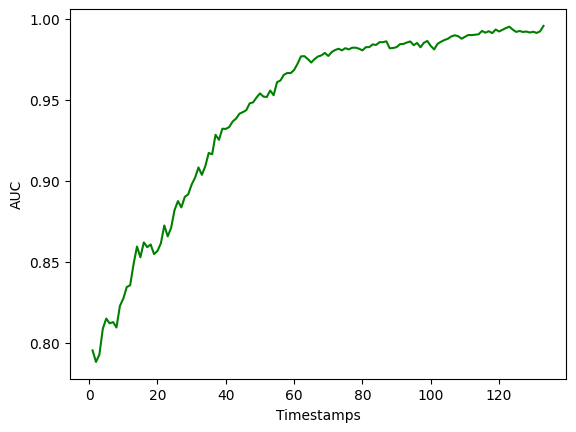

In [67]:
# Plot 
sns.lineplot(x="Timestamps", y="AUC", color = 'g',
             data=df)

# conservative: batching by 1 icu stay id


In [70]:
X_test, y_test = batch(test, 1) 
batches = len(X_test)
print(batches)

target = np.full((1), 100)
predicted_probabilities = np.full((1,1), 100)

prediction_per_id = []
y_per_id = []
sequence = []

i = 0
while i<batches: 
    sequence.append(X_test[i].shape[1])
    logits = nn_model_new(X_test[i])
    pred = torch.nn.Sigmoid() (logits)
    pred = pred.detach().numpy()
    pred = pred.reshape(-1,1)
    #print(pred.shape)
    predicted_probabilities = np.concatenate((predicted_probabilities,pred), axis=0)
    target = np.concatenate((target,y_test[i]), axis=0)
    prediction_per_id.append(pred)
    y_per_id.append(y_test[i])
    #print(y_test[i].shape)
    i +=1

target = np.delete(target, 0)
predicted_probabilities = np.delete(predicted_probabilities,0)
predicted_probabilities.shape

print ("Area Under ROC Curve: %0.2f" % roc_auc_score(target, predicted_probabilities, average = 'micro')  )
brier = round(metrics.brier_score_loss(target, predicted_probabilities, sample_weight=None, pos_label=None),3)
print("Brier score : {:.3f}".format(brier))

4776
Area Under ROC Curve: 0.82
Brier score : 0.146


In [71]:
sum = 0
for i in y_test:
    sum += i.shape[0]

In [72]:
# control
sum

174987

In [73]:
fpr, tpr, thresholds = roc_curve(target, predicted_probabilities)
# compute roc auc
roc_auc = roc_auc_score(target, predicted_probabilities, average = 'micro')
# compute Precision_Recall curves
precision, recall, _ = precision_recall_curve(target, predicted_probabilities)
# compute PR_AUC
pr_auc = metrics.auc(recall, precision)
# I add confusion matrix
optimal_cut_off = round(thresholds[np.argmax(tpr - fpr)],4)
a = np.where(predicted_probabilities > optimal_cut_off, 1, 0)
brier = round(metrics.brier_score_loss(target, predicted_probabilities, sample_weight=None, pos_label=None),3)
predictions = np.where(predicted_probabilities > optimal_cut_off, 1, 0)  

print ("Area Under ROC Curve: %0.2f" % roc_auc  )
print ("Area Under PR Curve(AP): %0.2f" % pr_auc  ) 
print("Brier score : {:.3f}".format(brier))
print('Accuracy for Classifier : {:.2f}'.format(accuracy_score(target, predictions)))
print('Cut off: ' + str(optimal_cut_off))
matrix = metrics.confusion_matrix(target, a, labels=None, normalize=None)
print(str(matrix))

Area Under ROC Curve: 0.82
Area Under PR Curve(AP): 0.53
Brier score : 0.146
Accuracy for Classifier : 0.75
Cut off: 0.3553
[[108084  35173]
 [  8278  23452]]


In [74]:
timestamps = 133 # max
icustays = len(X_test)
times = []
auc_s = []
t = 0

while t < timestamps:
    times.append((t+1)*6)
    i = 0
    prob_t = []
    y_t = []
    while i < icustays:
        this_id = prediction_per_id[i]
        this_y = y_per_id[i]
        try:         
            prob_t.append(this_id[t])
            y_t.append(this_y[t])
        except:
            pass
        i +=1
    #print('timestamp %d' %t)
    #print('length %d' %(len(prob_t)))
    prob_t = np.array(prob_t).reshape(-1,1)
    y_t = np.array(y_t).reshape(-1,1)
    try:
        auc_s.append(roc_auc_score(y_t, prob_t, average = 'micro'))
    except:
        print("missed timestamp: %d" %t)
    t +=1


In [75]:
df =  pd.DataFrame(auc_s, columns = ['AUC'])
df['Hours'] = times
#df[120:133]

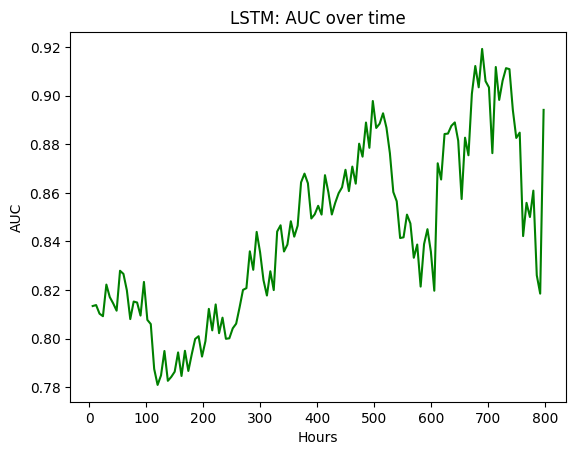

In [76]:
# Plot 
sns.lineplot(x="Hours", y="AUC", color = 'g',
             data=df)
plt.title('LSTM: AUC over time')
plt.savefig('LSTM_AUC over time.png', dpi = 300, bbox_inches='tight')

# Comparing to LogR, XGB, RF models

In [80]:
X_test, y_test = batch(test, test.shape[0]) 
X_test = X_test[0]
y_test = y_test[0]


def to_one_label (model, label_list,X_test,index_list):
    # evaluate on a test set
    labels = np.array(label_list)
    labels = labels.reshape(-1,1)
    labels = labels.astype(int)
    logits = model(X_test)
    pred = torch.nn.Sigmoid() (logits)
    max_rows = pred.shape[1]
    predictions = pred.detach().numpy()
    predictions = predictions.reshape(-1,1) 
    # select 1 per icu stay id by index
    prob_1_label = []
    row = 0
    prev = 0
    for i in index_list:
        prob_1_label.append(predictions[row+i-prev])
        row += pred.shape[1]
        prev = i
    prob_1_label = np.array(prob_1_label).reshape(-1,1)
    
    return labels, prob_1_label

In [81]:
def performance (y_test, pred_probabilities):
    # performance
    fpr, tpr, thresholds = roc_curve(y_test, pred_probabilities)
    # compute roc auc
    roc_auc = roc_auc_score(y_test, pred_probabilities, average = 'micro')
    # compute Precision_Recall curves
    precision, recall, _ = precision_recall_curve(y_test, pred_probabilities)
    # compute PR_AUC
    pr_auc = metrics.auc(recall, precision)
       
    # I add confusion matrix
    optimal_cut_off = round(thresholds[np.argmax(tpr - fpr)],4)
    a = np.where(pred_probabilities > optimal_cut_off, 1, 0)
    brier = round(metrics.brier_score_loss(y_test, pred_probabilities, sample_weight=None, pos_label=None),3)
    predictions = np.where(pred_probabilities > optimal_cut_off, 1, 0)  
    
    print ("Area Under ROC Curve: %0.2f" % roc_auc  )
    #print ("Area Under PR Curve(AP): %0.2f" % pr_auc  ) 
    print("Brier score : {:.3f}".format(brier))
    #print('Accuracy for Classifier : {:.2f}'.format(accuracy_score(y_test, predictions)))
    #print('Cut off: ' + str(optimal_cut_off))
    matrix = metrics.confusion_matrix(y_test, a, labels=None, normalize=None)
    

In [82]:
labels, prob_1_label = to_one_label (nn_model_new, label_list,X_test,index_list)
performance(labels,prob_1_label)

Area Under ROC Curve: 0.80
Brier score : 0.339


In [83]:
# save labels, prob_1_label (for calib graphs)
'''
with open('test.npy', 'wb') as f:
    #np.save(f, labels)
    np.save(f, prob_1_label)
with open('test.npy', 'rb') as f:
    #lstm_labels = np.load(f)
    lstm_prob = np.load(f)

'''  


"\nwith open('test.npy', 'wb') as f:\n    #np.save(f, labels)\n    np.save(f, prob_1_label)\nwith open('test.npy', 'rb') as f:\n    #lstm_labels = np.load(f)\n    lstm_prob = np.load(f)\n\n"

# Interpretability

In [ ]:
# To apply integrated gradients, we first create an IntegratedGradients object, providing the model object.
ig = IntegratedGradients(nn_model_new)
# To compute the integrated gradients, we use the attribute method of the IntegratedGradients object. The method takes
# tensor(s) of input examples (matching the forward function of the model), and returns the input attributions for the
# given examples. A target index, defining the index of the output for which gradients are computed is 1, 
# corresponding to AKI (1/0).

#The input tensor provided should require grad, so we call requires_grad_ on the tensor. The attribute method also 
# takes a baseline, which is the starting point from which gradients are integrated. The default value is just the 
# 0 tensor, which is a reasonable baseline / default for this task.

#The returned values of the attribute method are the attributions, which match the size of the given inputs, and delta,
# which approximates the error between the approximated integral and true integral.
print(datetime.now())
X_test.requires_grad_()
attr, delta = ig.attribute(X_test,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()
attr= np.reshape(attr,(-1,35))
importances = np.mean(attr, axis=0)
print(datetime.now())

2023-04-01 10:48:30.320400


In [65]:
def visualize_feature_importances(feature_names, importances, title="LSTM Average Feature Importances", axis_title="Features"):
    print(title)
    i = 0
    while i < features:
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
        i +=1
    x_pos = (np.arange(len(feature_names)))
    
visualize_feature_importances(feature_names, importances)


LSTM Average Feature Importances
Anion gap :  0.003
Bicarbonate :  0.001
Blood Urea Nitrogen :  -0.000
Chloride :  -0.005
Creatinine :  0.008
Diastolic BP :  0.002
Glucose :  0.002
Heart rate :  0.002
Hematocrit :  0.000
Hemoglobin :  0.000
Potassium :  0.006
Respiratory rate :  0.002
Sodium :  -0.002
Oxygen saturation :  0.005
Systolic BP :  0.001
Urine output 12h :  0.001
Urine output 24h :  0.003
Urine output 6h :  -0.014
White cell count :  0.000
Sedative :  0.000
Vasopressor :  -0.000
Ventilation :  0.000
Age :  -0.001
Female gender :  0.003
Male gender :  0.003
Asian ethnicity :  -0.000
Black ethnicity :  -0.000
Hispanic ethnicity :  -0.000
Native american :  0.000
Other ethnicity :  -0.000
Ethnicity unknown :  -0.001
White ethnicity :  -0.002
Elective admission :  0.001
Emergency admission :  0.001
Urgent admission :  0.000


In [66]:
lstm_df =  pd.DataFrame(importances, columns = ['Feature Importance'])
lstm_df['Features'] = feature_names
lstm_df = lstm_df.sort_values(by = ['Feature Importance'], ascending = False, ignore_index = True)
#lstm_df

In [67]:
lstm_df["Feature Importance"].sum()

0.018777688236784912

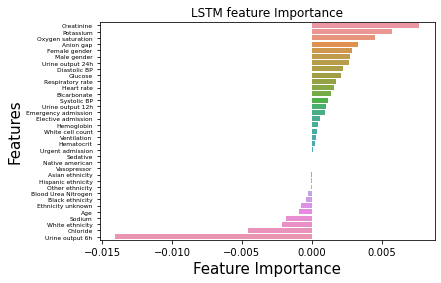

In [68]:
#ax = sns.barplot(x='Feature Importance', y='Features', data=lstm_df)
ax = sns.barplot(x='Feature Importance', y='Features', data=lstm_df)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('LSTM feature Importance')
plt.savefig('LSTM_feature_importance_grey.png', dpi = 300, bbox_inches='tight')

In [51]:
lstm_df

,Feature Importance,Features
0,0.007704,Creatinine
1,0.005759,Potassium
2,0.004547,Oxygen saturation
3,0.003341,Anion gap
4,0.002875,Female gender
5,0.002736,Male gender
6,0.002635,Urine output 24h
7,0.002219,Diastolic BP
8,0.002124,Glucose
9,0.001762,Respiratory rate


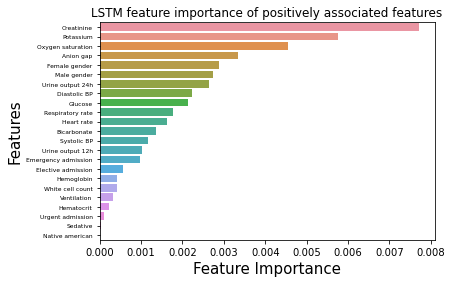

In [53]:
# positive
positiveLSTM = lstm_df[0:23]
ax = sns.barplot(x='Feature Importance', y='Features', data=positiveLSTM)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('LSTM feature importance of positively associated features')
plt.savefig('LSTM_feature_importance_pos.png', dpi = 300, bbox_inches='tight')

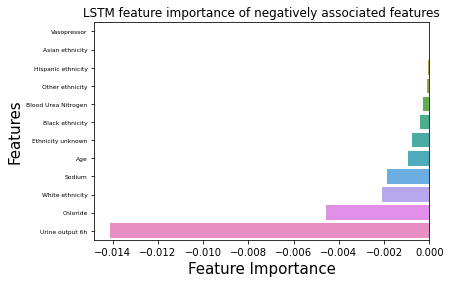

In [54]:
# negative
negativeLSTM = lstm_df[23:35]
ax = sns.barplot(x='Feature Importance', y='Features', data=negativeLSTM)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('LSTM feature importance of negatively associated features')
#plt.xlim(0.98, 1.075)
plt.savefig('LSTM_feature_importance_neg.png', dpi = 300, bbox_inches='tight')

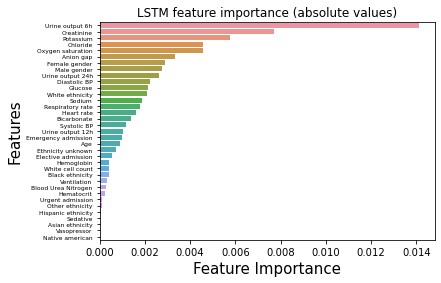

In [55]:
lstm_df['abs'] = abs(lstm_df['Feature Importance'])
lstm_df = lstm_df.sort_values(by = ['abs'], ascending = False, ignore_index = True)
ax = sns.barplot(x='abs', y='Features', data=lstm_df)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
#plt.xlim(0.91, 1.075)
plt.title('LSTM feature importance (absolute values)')
plt.savefig('LSTM_feature_importance_absolute.png', dpi = 300, bbox_inches='tight')

In [55]:
lstm_df['abs'] = abs(lstm_df['Feature Importance'])
lstm_df = lstm_df.sort_values(by = ['abs'], ascending = False, ignore_index = True)
lstm_df_10 = lstm_df.head(10)
#lstm_df_10

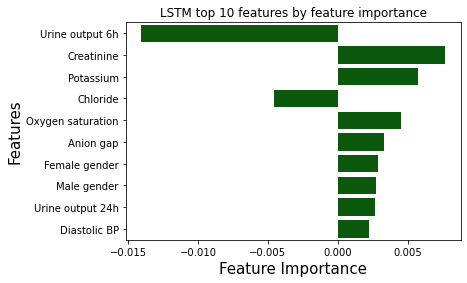

In [66]:
#ax = sns.barplot(x='Feature Importance', y='Features', data=lstm_df_10, palette="mako")

ax = sns.barplot(x='Feature Importance', y='Features', data=lstm_df_10, color = 'darkgreen')
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
plt.title('LSTM top 10 features by feature importance')
plt.savefig('LSTM_top10_feature_importance_darkgreen.png', dpi = 300, bbox_inches='tight')

# SHAP

In [87]:
nn_model_new

new_Net3(
  (layer1): Sequential(
    (0): Linear(in_features=35, out_features=35, bias=True)
    (1): ELU(alpha=1.0)
    (2): LSTM(35, 1, num_layers=3, batch_first=True, bidirectional=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=1, out_features=1, bias=True)
  )
)

In [ ]:
# shap 1000
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

import shap
shap.initjs()

lstm_explainer = shap.DeepExplainer(nn_model_new, X_test)
X_demo_shap = X_test[0:1000,:,:]
lstm_shap_values = lstm_explainer.shap_values(X_demo_shap)


In [55]:
len(lstm_shap_values) # 133
print(len(lstm_shap_values[0])) # sample size
len(lstm_shap_values[0][0]) # 133
len(lstm_shap_values[0][0][0]) # 35
# print(lstm_shap_values)

# choose the appropriate timestamp
lstm_shap_values_48h = []
for i in range(len(X_demo_shap)):
    shap_index = timestamp_each[i]
    sh = lstm_shap_values[shap_index][i].reshape(1,133*35)
    lstm_shap_values_48h.append(sh)
lstm_shap_values_48h = np.array(lstm_shap_values_48h).reshape(len(X_demo_shap),133*35) # make sure shape, so don't use -1
lstm_X_values = X_demo_shap.reshape(len(X_demo_shap), 133*35)

print(lstm_shap_values_48h.shape)
print(lstm_X_values.shape)

1000
(1000, 4655)
torch.Size([1000, 4655])


In [56]:
variables = ['Anion gap', 'Bicarbonate', 'Blood Urea Nitrogen', 'Chloride', 'Creatinine', 'Diastolic BP', 'Glucose', 'Heart rate', 
            'Hematocrit', 'Hemoglobin', 'Potassium', 'Respiratory rate', 'Sodium', 'Oxygen saturation', 'Systolic BP', 'Urine output 12h', 'Urine output 24h', 'Urine output 6h',
            'White cell count', 'Sedative', 'Vasopressor', 'Ventilation', 'Age', 'Female gender', 'Male gender', 'Asian ethnicity', 'Black ethnicity', 'Hispanic ethnicity', 'Native american', 
            'Other ethnicity', 'Ethnicity unknown', 'White ethnicity', 'Elective admission', 'Emergency admission', 'Urgent admission']
timestamps = 133

In [57]:
# get mean by feature over the timestamps
def mean_over_timestamps(n, shap_values, X):
    a = []
    b = []
    i = 0
    f = 0
    while f < len(feature_names):
        temp_a = 0 # sum of a feature shap
        temp_b = 0 #sum of feature
        i = i+f
        counter = 0
        while counter < timestamps:
            temp_a += shap_values[n][i]
            temp_b += X[n][i]
            i+=len(feature_names)
            counter +=1
        a.append(temp_a/timestamps) #mean shap
        b.append(temp_b/timestamps) #mean feature
        i = 0
        f +=1
    a = np.array(a).reshape((1,-1))
    b = np.array(b).reshape((1,-1))
    return a,b

In [58]:
# for the first istance
lstm_shap_mean, lstm_X_mean = mean_over_timestamps(0,lstm_shap_values_48h,lstm_X_values)
n = 1
while n < lstm_X_values.shape[0]:
    a,b = mean_over_timestamps(n, lstm_shap_values_48h,lstm_X_values)
    n+=1
    lstm_shap_mean = np.concatenate((lstm_shap_mean, a), axis=0)
    lstm_X_mean = np.concatenate((lstm_X_mean, b), axis=0)

In [60]:
shap.initjs()
lstm_X_mean = pd.DataFrame(lstm_X_mean, columns= feature_names)
single_index = 1
single_shap_lstm = lstm_shap_mean[single_index,:]
single_X_lstm = lstm_X_mean[single_index:single_index+1]
# visualize single prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(lstm_explainer.expected_value[timestamp_each[single_index]], single_shap_lstm, single_X_lstm)

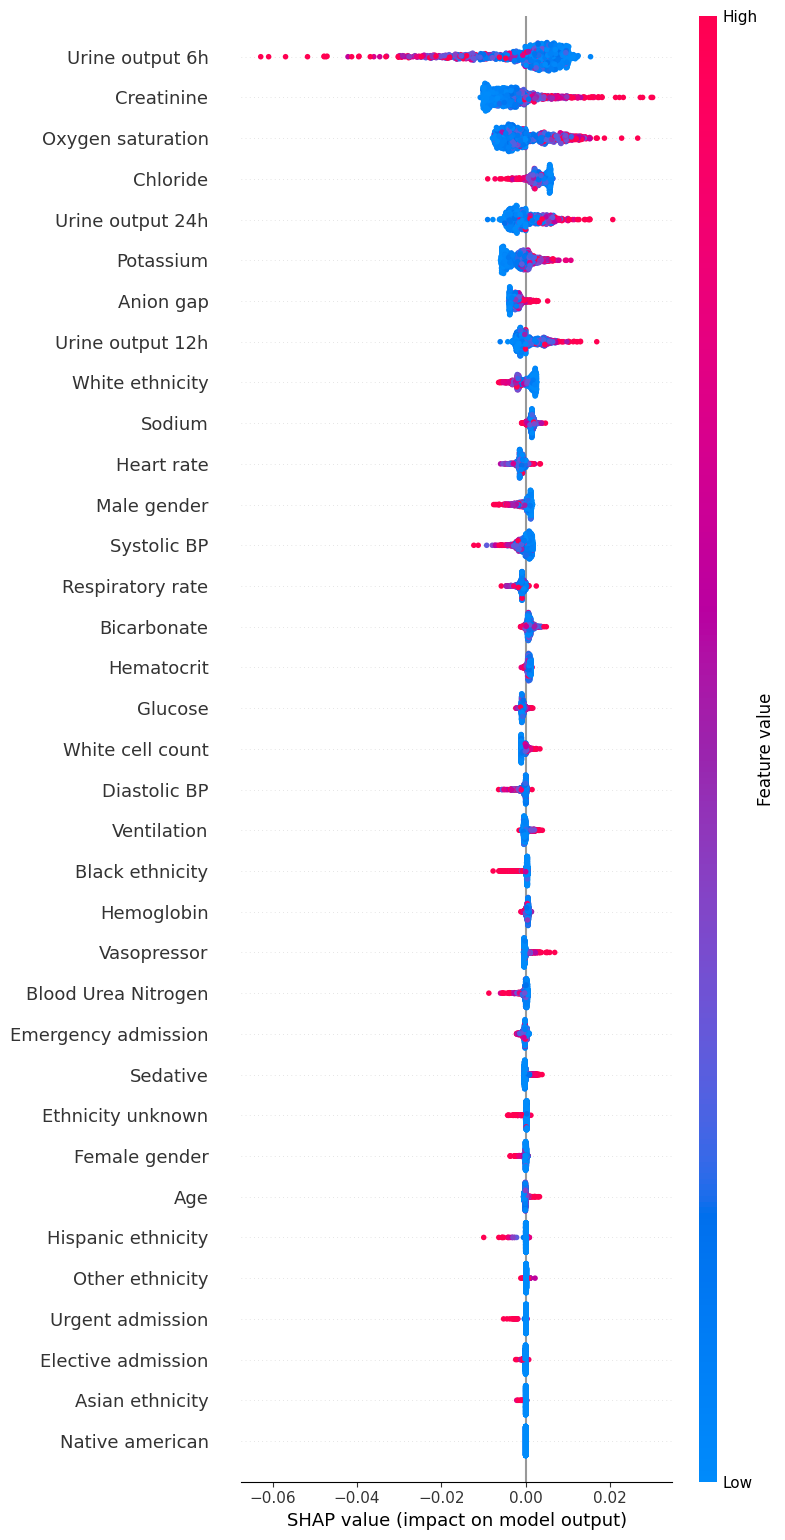

<Figure size 640x480 with 0 Axes>

In [64]:
# summarize the effects of all the features (1000)
shap.summary_plot(lstm_shap_mean, lstm_X_mean,max_display=X_test.shape[1])
plt.savefig('LSTM_shap summary.png', dpi = 300, bbox_inches='tight')

# graphs

In [77]:
def build_graphs (y_test,pred_probabilities, classifier_name, plot_name, algorithm):
    
    def bin_total(y_true, y_prob, n_bins):
        bins = np.linspace(0., 1. + 1e-8, n_bins + 1)

        # In sklearn.calibration.calibration_curve, the last value in the array is always 0.
        binids = np.digitize(y_prob, bins) - 1

        return np.bincount(binids, minlength=len(bins))

    def missing_bin(bin_array):
        midpoint = " "    
        if bin_array[0]==0:
            midpoint = "5%, "
        if bin_array[1]==0:
            midpoint = midpoint + "15%, "
        if bin_array[2]==0:
            midpoint = midpoint + "25%, "
        if bin_array[3]==0:
            midpoint = midpoint + "35%, " 
        if bin_array[4]==0:
            midpoint = midpoint + "45%, "
        if bin_array[5]==0:
            midpoint = midpoint + "55%, "
        if bin_array[6]==0:
            midpoint = midpoint + "65%, "
        if bin_array[7]==0:
            midpoint = midpoint + "75%, "
        if bin_array[8]==0:
            midpoint = midpoint + "85%, "
        if bin_array[9]==0:
            midpoint = midpoint + "95%, "
        return "The missing bins have midpoint values of "+ str(midpoint)
    
    # performance
    fpr, tpr, thresholds = roc_curve(y_test, pred_probabilities)
    # compute roc auc
    roc_auc = roc_auc_score(y_test, pred_probabilities, average = 'micro')
    # compute Precision_Recall curves
    precision, recall, _ = precision_recall_curve(y_test, pred_probabilities)
    # compute PR_AUC
    pr_auc = metrics.auc(recall, precision)

    # compute calibration curve
    LR_y, LR_x = calibration_curve(y_test, pred_probabilities, n_bins=10)
    #find out which one are the missing bins
    bin_array = bin_total(y_test, pred_probabilities , n_bins=10)
    print(missing_bin(bin_array))

    print("plot curves and save in one png file")
    #save three plots in one png file
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(7, 24))
    fig.subplots_adjust(wspace=0.3, hspace= 0.3)
    fig.suptitle('Evaluation of '+ plot_name)

    fpr, tpr, thresholds = roc_curve(y_test, pred_probabilities)
    
    # plot roc curve
    ax1.plot(fpr, tpr,'C2', label=algorithm+" "+"Classifier " + str(classifier_name) + ", auc=" +str(round(roc_auc,2)))
    ax1.title.set_text('ROC AUC')
    ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax1.legend(loc="lower right")

    # plot PR curve
    ax2.plot(recall, precision,'C2', label=algorithm+" "+"Classifier " + str(classifier_name) + ", auc="+str(round(pr_auc,2)))
    ax2.title.set_text('PR AUC')
    ax2.set(xlabel='Recall', ylabel='Precision')
    ax2.legend(loc="lower right")

    # plot calibration curve
    ax3.plot(LR_x, LR_y, 'C2',marker='o', linewidth=1, label='LSTM')
    line = mlines.Line2D([0, 1], [0, 1], color='black')
    transform = ax3.transAxes
    line.set_transform(transform)
    ax3.add_line(line)
    ax3.title.set_text('Calibration plot for '+str(plot_name))
    ax3.set(xlabel= 'Predicted probability', ylabel= 'True probability in each bin')
    ax3.legend(loc="lower right")

    plt.savefig(plot_name+".png")
    plt.show()
    

In [78]:
def distribution(pred_probabilities, y_test, dist_name):
    #probabilities distributions graphs
    true_1 = pd.DataFrame(pred_probabilities, columns=['Predicted probabilities'])
    true_1['labels'] = y_test.tolist()
    true_0 = true_1.copy(deep = True) 
    indexNames = true_1[true_1['labels'] == 0].index
    true_1.drop(indexNames , inplace=True)
    indexNames = true_0[ true_0['labels'] == 1 ].index
    true_0.drop(indexNames , inplace=True)
    true_1.drop(columns=['labels'], inplace = True)
    true_0.drop(columns=['labels'], inplace = True)
    
    sns.distplot(true_1['Predicted probabilities'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3,"color": "g"}, label = 'Class 1')
    plt.ylabel('Density')
    sns.distplot(true_0['Predicted probabilities'], hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3}, label = 'Class 0')
    plt.title('Density Plot'+ dist_name)
    

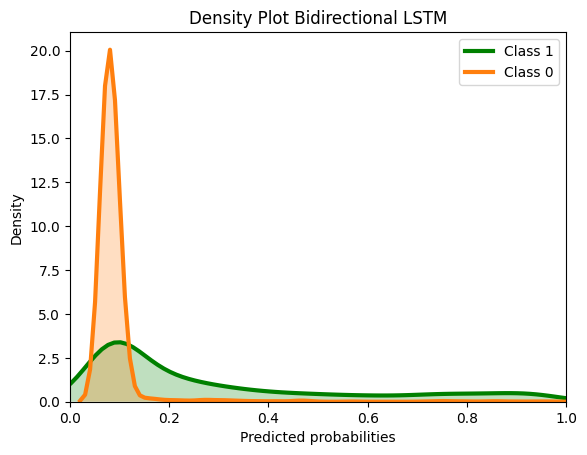

In [84]:
distribution(prob_1_label, labels.flatten(), " Bidirectional LSTM")
plt.xlim(0.0, 1.00)
plt.savefig('worst.png')

The missing bins have midpoint values of  
plot curves and save in one png file


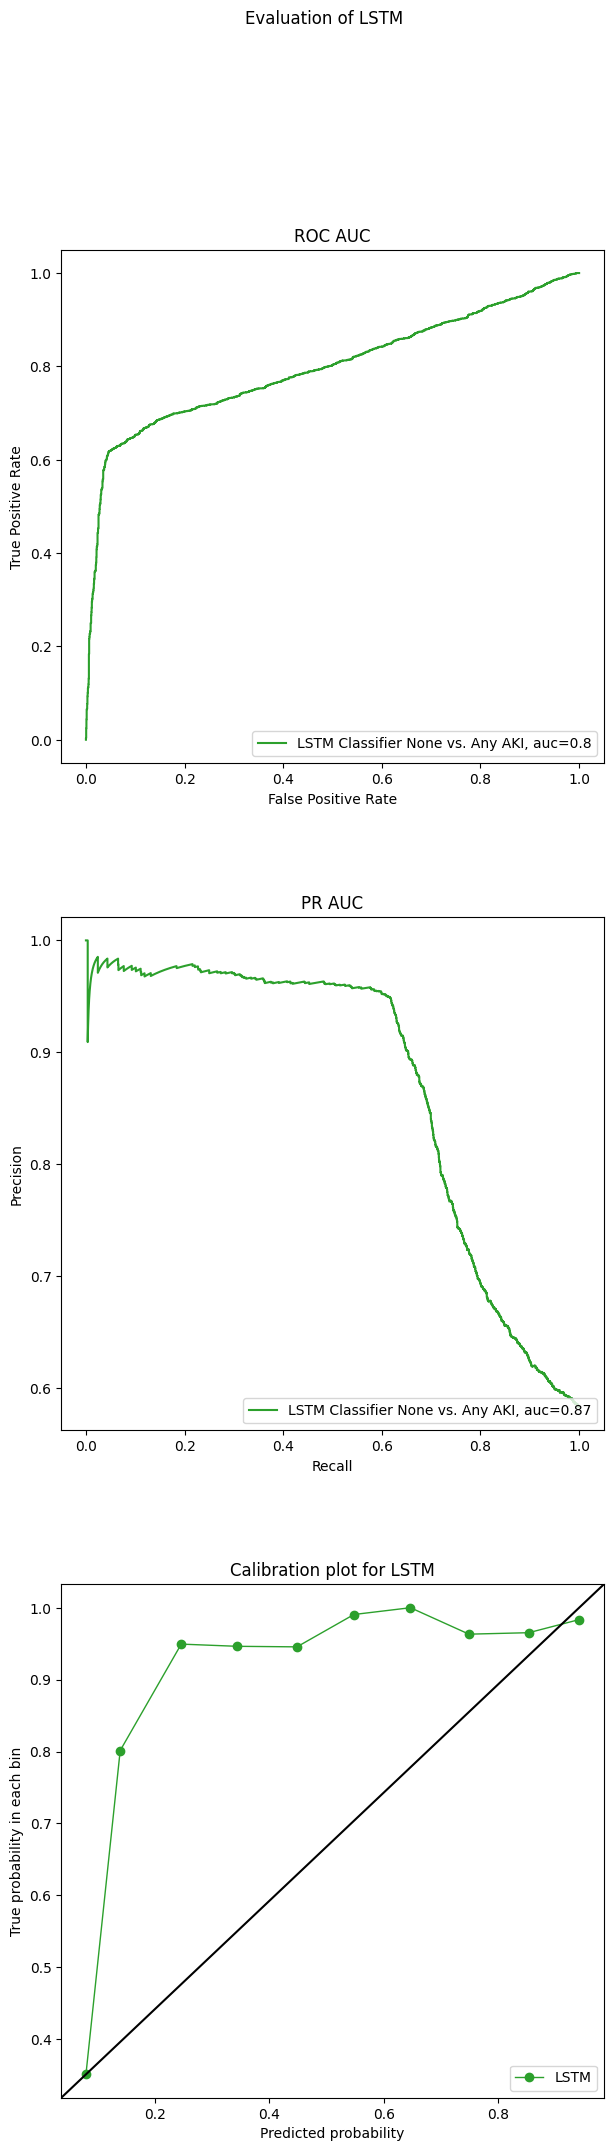

In [85]:
classifier_name = "None vs. Any AKI"    ###change every time #Moderate vs. Severe #None vs. Any #Others vs. Severe
plot_name = "LSTM"
build_graphs(labels.flatten(), prob_1_label.flatten(), classifier_name, plot_name, "LSTM")


F1 = 0.747, PR auc =0.873


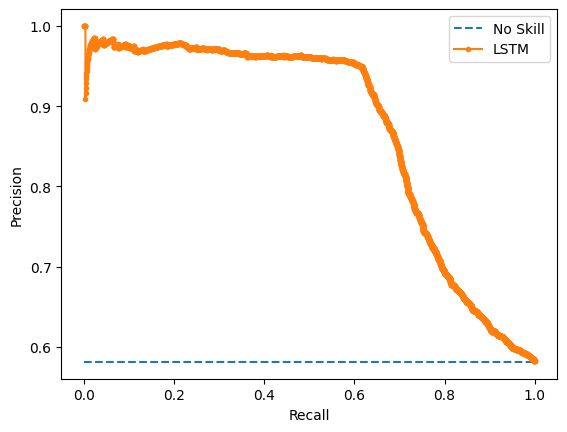

In [86]:
precision, recall, thresholds = precision_recall_curve(labels, prob_1_label)
fpr, tpr, thresholds = roc_curve(labels, prob_1_label)
optimal_cut_off = round(thresholds[np.argmax(tpr - fpr)],2)
prediction = np.where(prob_1_label > optimal_cut_off, 1, 0)
f1 = f1_score(labels,prediction)
prauc =auc(recall, precision)
print('F1 = %.3f, PR auc =%.3f' % (f1,prauc))

# plot the precision-recall curves
no_skill = len(labels[labels==1]) / len(labels)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall,precision, marker='.', label='LSTM')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()



# Hyperparameters tuning (manual loop)

In [ ]:
# search grid 
layers = [1,2,3]
l_rate = [0.001, 0.0001]
drop = [0,0.2]
bidirectionality = [True,False]
#loops count
hypercount = 0
# static parameters
n_epochs = 80
emb_size = round(features/1)
input_size = features
output_size = 1
###############################

f = open('lstm_no_imp_uni.txt', 'w+') #change with or without imp

for q1 in bidirectionality:
    for q2 in layers:
        for q3 in drop:
            for q4 in l_rate:
                hypercount +=1
                name = "i-Bidir_" if q1 else "i-Onedir_"
                name = name+str(q2) + "_lr_"+str(q4)
                name = name+"_drop"+str(q3) if q3 == 0.2 else name+"_nodrop"
                #set parameters
                bi_directional = q1
                lr = q4
                number_layers = q2
                dropout = q3 # dropout
                print('hypercount: %d' % hypercount)
                print('\n')
                print(name)
                f.write('\n\n' + str(name)+ '\n\n')
                    
                # create the NN
                class Net(nn.Module):
                    def __init__(self, input_size, emb_size, output_size, bi_directional, number_layers, dropout):
                        super(Net, self).__init__()
                        self.input_size = input_size
                        self.emb_size = emb_size 
                        self.output_size = output_size
                        self.number_layers = number_layers
                        self.fc1 = nn.Linear(self.input_size, self.emb_size, bias = True) # I can have a few (IV) within this line - documentation        
                        self.fc2 = nn.LSTM(self.emb_size, self.output_size,num_layers=self.number_layers, batch_first = True, bidirectional = bi_directional) 
                        # in bidirectional encoder we have  forward and backward hidden states
                        self.encoding_size = self.output_size * 2 if bi_directional else self.output_size
                        self.combination_layer = nn.Linear(self.encoding_size, self.encoding_size)
                        # Create affine layer to project to the classes 
                        self.projection = nn.Linear(self.encoding_size, self.output_size)
                        #dropout layer for regularizetion of a sequence
                        self.dropout_layer = nn.Dropout(p = dropout)  
                        self.relu = nn.ReLU()

                    def forward(self, x):
                        h = self.relu(self.fc1(x))
                        h, _ = self.fc2(h) # h, _ : as I have 2outputs (tuple), only take the real output [0]. 
                        #print(type(h)) # Underscore throughs away the rest, _ "I do not care" variable notation in python
                        h = self.relu(self.combination_layer(h))
                        h = self.dropout_layer(h)
                        h = self.projection(h) 
                        return h

                #create a network 
                nn_model = Net(input_size, emb_size, output_size,bi_directional, number_layers, dropout)
                print(nn_model)
                #print(list(nn_model.parameters()))
                
                # BCE Loss and optimizer
                criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(round(zeroes/ones,0))) # class imbalance
                #print(round(zeroes/ones,0))
                optimizer = optim.Adam(nn_model.parameters(), lr=lr) 
    
    
                # TRAINING LOOP 
                epochs = n_epochs
                starttime = datetime.now() # datetime object containing current date and time
                train_losses, validation_losses = [], []
                best = 0
                patience = 0
                old_auc = 0
                old_pr = 0

                for epoch in range(epochs):  # loop over the dataset multiple times
                    print ("\n Epoch [%d] out of %d" % (epoch + 1, epochs))
                    running_loss = 0.0
                    validation_loss = 0.0
                    roc_auc = 0.0
                    pr_auc = 0.0
                    m = 0
                    
                    #train
                    #print(list(nn_model.parameters())[0])
                    for i in X_train:
                        # zero the parameter gradients
                        optimizer.zero_grad() # zero the gradient buffers not to consider gradients of previous iterations
                        X_batch = X_train[m]
                        y_batch = y_train[m]
                        # forward + backward + optimize
                        outputs = nn_model(X_batch)
                        outputs = torch.flatten(outputs)
                        y_batch = y_batch.type_as(outputs)
                        loss = criterion(outputs, y_batch)
                        loss.backward()
                        optimizer.step() # Does the update
                        running_loss += loss.item()
                        m +=1
                    #validation 
                    nn_model.eval()
                    with torch.no_grad():
                        v_out = nn_model(X_val) 
                        v_out = torch.flatten(v_out) 
                        y_val = y_val.type_as(v_out)
                        v_loss = criterion(v_out, y_val)
                        validation_loss = v_loss.item()
                        # auc and pr auc
                        val_prob = torch.nn.Sigmoid() (v_out)
                        precision, recall, thresholds = precision_recall_curve(y_val, val_prob)
                        pr_auc = auc(recall, precision)
                        roc_auc = roc_auc_score(y_val,val_prob) 

                    validation_losses.append(validation_loss) 
                    train_losses.append(running_loss/len(X_train)) 
                    print(f"Training loss: {running_loss/len(X_train):.3f}.. " f"Validation loss: {validation_loss:.3f}.. ")
                    print(f"AUC: {roc_auc:.2f} " f"PR AUC: {pr_auc:.2f} ")  
                    nn_model.train()

                    
                    if roc_auc > best:
                        best = roc_auc
                        PATH1 = './'+str(name)+'best.pth' 
                        torch.save(nn_model.state_dict(), PATH1) # save the model
                    else:
                        pass
                    
                    if roc_auc == old_auc and pr_auc==old_pr:
                        patience +=1
                    old_auc = roc_auc
                    old_pr = pr_auc
                    if patience ==10:
                        print("out of patience")
                        break

                print('\n Finished Training')
                print("starttime =", starttime)
                now = datetime.now()
                print("endtime =", now)
                # end of training loop
                
                PATH2 = './'+str(name)+'last.pth' 
                torch.save(nn_model.state_dict(), PATH2) # save the model
                print('\n Last model \n')
                labels, probs = to_one_label(nn_model,label_list,X_test,index_list)
                performance (nn_model, labels, probs)
                
                #load the best model
                best_model = Net(input_size, emb_size, output_size,bi_directional, number_layers, dropout)
                best_model.load_state_dict(torch.load(PATH1))
                print('\n Best model \n')
                labels, probs = to_one_label(best_model,label_list,X_test,index_list)
                performance (best_model, labels, probs)
f.close() 
        

In [ ]:
# enhanced version of deepexplainer
from .deep_pytorch import PyTorchDeepExplainer
from shap.explainers.explainer import Explainer


class DeepExplainer(Explainer):
    """ Meant to approximate SHAP values for deep learning models.
    This is an enhanced version of the DeepLIFT algorithm (Deep SHAP) where, similar to Kernel SHAP, we
    approximate the conditional expectations of SHAP values using a selection of background samples.
    Lundberg and Lee, NIPS 2017 showed that the per node attribution rules in DeepLIFT (Shrikumar,
    Greenside, and Kundaje, arXiv 2017) can be chosen to approximate Shapley values. By integrating
    over many backgound samples DeepExplainer estimates approximate SHAP values such that they sum
    up to the difference between the expected model output on the passed background samples and the
    current model output (f(x) - E[f(x)]).
    """

    def __init__(self, model, data, session=None, learning_phase_flags=None):
        # first, we need to find the framework
        if type(model) is tuple:
            a, b = model
            try:
                a.named_parameters()
                framework = 'pytorch'
            except:
                framework = 'tensorflow'
        else:
            try:
                model.named_parameters()
                framework = 'pytorch'
            except:
                framework = 'tensorflow'

        if framework == 'tensorflow':
            self.explainer = TFDeepExplainer(model, data, session, learning_phase_flags)
        elif framework == 'pytorch':
            self.explainer = PyTorchDeepExplainer(model, data)

    def shap_values(self, X, ranked_outputs=None, output_rank_order='max'):
        """ Return approximate SHAP values for the model applied to the data given by X.
        Parameters
        ----------
        X : list, numpy.array, or pandas.DataFrame
            A tensor (or list of tensors) of samples (where X.shape[0] == # samples) on which to
            explain the model's output.
        ranked_outputs : None or int
            If ranked_outputs is None then we explain all the outputs in a multi-output model. If
            ranked_outputs is a positive integer then we only explain that many of the top model
            outputs (where "top" is determined by output_rank_order). Note that this causes a pair
            of values to be returned (shap_values, indexes), where shap_values is a list of numpy
            arrays for each of the output ranks, and indexes is a matrix that indicates for each sample
            which output indexes were choses as "top".
        output_rank_order : "max", "min", or "max_abs"
            How to order the model outputs when using ranked_outputs, either by maximum, minimum, or
            maximum absolute value.
        Returns
        -------
        For a models with a single output this returns a tensor of SHAP values with the same shape
        as X. For a model with multiple outputs this returns a list of SHAP value tensors, each of
        which are the same shape as X. If ranked_outputs is None then this list of tensors matches
        the number of model outputs. If ranked_outputs is a positive integer a pair is returned
        (shap_values, indexes), where shap_values is a list of tensors with a length of
        ranked_outputs, and indexes is a matrix that indicates for each sample which output indexes
        were chosen as "top".
        """
        return self.explainer.shap_values(X, ranked_outputs, output_rank_order)

import warnings
from shap.explainers.explainer import Explainer
from distutils.version import LooseVersion
torch = None


class PyTorchDeepExplainer(Explainer):

    def __init__(self, model, data):
        # try and import pytorch
        global torch
        if torch is None:
            import torch
            if LooseVersion(torch.__version__) < LooseVersion("0.4"):
                warnings.warn("Your PyTorch version is older than 0.4 and not supported.")

        # check if we have multiple inputs
        self.multi_input = False
        if type(data) == list:
            self.multi_input = True
        if type(data) != list:
            data = [data]
        # for consistency, the method signature calls for data as the model input.
        # However, within this class, self.model_inputs is the input (i.e. the data passed by the user)
        # and self.data is the background data for the layer we want to assign importances to. If this layer is
        # the input, then self.data = self.model_inputs
        self.model_inputs = data
        self.layer = None
        self.input_handle = None
        self.interim = False
        if type(model) == tuple:
            self.interim = True
            model, layer = model
            model = model.eval()
            self.add_target_handle(layer)
            self.layer = layer

            # now, if we are taking an interim layer, the 'data' is going to be the input
            # of the interim layer; we will capture this using a forward hook
            with torch.no_grad():
                _ = model(*data)
                interim_inputs = self.layer.target_input
                if type(interim_inputs) is tuple:
                    # this should always be true, but just to be safe
                    self.data = [torch.tensor(i) for i in interim_inputs]
                else:
                    self.data = [torch.tensor(interim_inputs)]
        else:
            self.data = data
        self.model = model.eval()

        # now, get the expected model mean and outputs
        # note that this will also conveniently add all the reference values
        self.multi_output = False
        with torch.no_grad():
            outputs = model(*data)
            self.expected_value = outputs.mean(0)
            if outputs.shape[1] > 1:
                self.multi_output = True
                self.num_outputs = outputs.shape[1]
        if self.interim:
            self.target_handle.remove()

    def add_target_handle(self, layer):
        input_handle = layer.register_forward_hook(self.get_target_input)
        self.target_handle = input_handle

    @staticmethod
    def get_target_input(module, input, output):
        """Saves the tensor - attached to its graph.
        Used if we want to explain the interim outputs of a model
        """
        try:
            del module.target_input
        except AttributeError:
            pass
        setattr(module, 'target_input', input)

    @staticmethod
    def add_interim_values(module, input, output):
        """Saves interim tensors detached from the graph.
        Used to calculate multipliers
        """
        try:
            del module.x
        except AttributeError:
            pass
        if type(input) is tuple:
            setattr(module, 'x', tuple(i.detach() for i in input))
        else:
            setattr(module, 'x', input.detach())

        try:
            del module.y
        except AttributeError:
            pass
        if type(output) is tuple:
            setattr(module, 'y', tuple(o.detach() for o in output))
        else:
            setattr(module, 'y', output.detach())

    @staticmethod
    def deeplift_grad(module, grad_input, grad_output):
        # first, get the module type
        type = module.__class__.__name__
        # first, check its not a container
        if type in op_handler:
            return op_handler[type](module, grad_input, grad_output)
        else:
            print('Warning: unrecognized nn.Module: {}'.format(type))
            return grad_input

    def gradient(self, idx, inputs):
        self.model.zero_grad()
        X = [x.requires_grad_() for x in inputs]
        outputs = self.model(*X)
        selected = [val for val in outputs[:, idx]]
        if self.input_handle is not None:
            interim_inputs = self.layer.target_input
            grads = [torch.autograd.grad(selected, input)[0].cpu().numpy() for input in interim_inputs]
            del self.layer.target_input
        else:
            grads = [torch.autograd.grad(selected, x)[0].cpu().numpy() for x in X]
        return grads

    def shap_values(self, X, ranked_outputs=None, output_rank_order="max"):

        # X ~ self.model_input
        # X_data ~ self.data

        # check if we have multiple inputs
        if not self.multi_input:
            assert type(X) != list, "Expected a single tensor model input!"
            X = [X]
        else:
            assert type(X) == list, "Expected a list of model inputs!"

        if ranked_outputs is not None and self.multi_output:
            with torch.no_grad():
                model_output_values = self.model(*X)
            # rank and determine the model outputs that we will explain
            if output_rank_order == "max":
                _, model_output_ranks = torch.sort(model_output_values, descending=True)
            elif output_rank_order == "min":
                _, model_output_ranks = torch.sort(model_output_values, descending=False)
            elif output_rank_order == "max_abs":
                _, model_output_ranks = torch.sort(torch.abs(model_output_values), descending=True)
            else:
                assert False, "output_rank_order must be max, min, or max_abs!"
            model_output_ranks = model_output_ranks[:, :ranked_outputs]
        else:
            model_output_ranks = (torch.ones((X[0].shape[0], self.num_outputs)).int() *
                                  torch.arange(0, self.num_outputs).int())

        # add the gradient handles
        gradient_handles = []
        interim_handles = []
        for child in self.model.children():
            if 'nn.modules.container' in str(type(child)):
                for subchild in child.children():
                    interim_handles.append(subchild.register_forward_hook(self.add_interim_values))
                    gradient_handles.append(subchild.register_backward_hook(self.deeplift_grad))
            else:
                interim_handles.append(child.register_forward_hook(self.add_interim_values ))
                gradient_handles.append(child.register_backward_hook(self.deeplift_grad))

        # compute the attributions
        output_phis = []
        for i in range(model_output_ranks.shape[1]):
            phis = []
            for k in range(len(X)):
                phis.append(np.zeros(X[k].shape))
            for j in range(X[0].shape[0]):
                # tile the inputs to line up with the background data samples
                tiled_X = [X[l][j:j + 1].repeat(
                                   (self.data[l].shape[0],) + tuple([1 for k in range(len(X[l].shape) - 1)])) for l
                           in range(len(X))]
                joint_x = [torch.cat((tiled_X[l], self.model_inputs[l]), dim=0) for l in range(len(X))]
                # run attribution computation graph
                feature_ind = model_output_ranks[j, i]
                sample_phis = self.gradient(feature_ind, joint_x)
                # assign the attributions to the right part of the output arrays
                for l in range(len(X)):
                    phis[l][j] = (sample_phis[l][self.data[l].shape[0]:] * (X[l][j: j + 1] - self.data[l])).mean(0)
            output_phis.append(phis[0] if not self.multi_input else phis)
        # cleanup; remove all gradient handles
        for handle in gradient_handles:
            handle.remove()
        # TODO remove all attributes given to the modules

        if not self.multi_output:
            return output_phis[0]
        elif ranked_outputs is not None:
            return output_phis, model_output_ranks
        else:
            return output_phis


def passthrough(module, grad_input, grad_output):
    """No change made to gradients"""
    return grad_input


def maxpool(module, grad_input, grad_output):

    pool_to_unpool = {
        'MaxPool1d': torch.nn.functional.max_unpool1d,
        'MaxPool2d': torch.nn.functional.max_unpool2d,
        'MaxPool3d': torch.nn.functional.max_unpool1d
    }
    x, ref_input = torch.chunk(module.x[0], 2)
    delta_in = x - ref_input
    dup0 = [2] + [1 for i in delta_in.shape[1:]]
    # we also need to check if the output is a tuple
    if type(module.y) is tuple:
        y, ref_output = torch.chunk(module.y[0], 2)
    else:
        y, ref_output = torch.chunk(module.y, 2)

    cross_max = torch.where(y > ref_output, y, ref_output)

    diffs = torch.cat([cross_max - ref_output, y - cross_max], 0)

    # all of this just to unpool the outputs
    temp_module = getattr(torch.nn, module.__class__.__name__)(
        module.kernel_size, module.stride, module.padding, module.dilation,
        return_indices=True, ceil_mode=module.ceil_mode)
    _, indices = temp_module(module.x[0])

    unpooled = pool_to_unpool[module.__class__.__name__](
        grad_output[0] * diffs, indices, module.kernel_size, module.stride,
        module.padding, delta_in.shape)
    xmax_pos, rmax_pos = torch.chunk(unpooled, 2)
    # handles numerical instabilities where delta_in is very small by
    # just taking the gradient in those cases
    grads = [None for _ in grad_input]
    grads[0] = torch.where(torch.abs(delta_in) < 1e-7, torch.zeros_like(delta_in),
                           (xmax_pos + rmax_pos) / delta_in).repeat(dup0)
    return tuple(grads)


def linear_1d(module, grad_input, grad_output):
    for i in range(len(module.x)):
        if i != 0 and type(module.y) is tuple:
            assert module.x[i] == module.y[i], "Only the 0th input may vary!"
    return grad_input


def nonlinear_1d(module, grad_input, grad_output):
    # check only the 0th input varies
    for i in range(len(module.x)):
        if i != 0 and type(module.y) is tuple:
            assert module.x[i] == module.y[i], "Only the 0th input may vary!"

    # we also need to check if the output is a tuple
    if type(module.y) is tuple:
        y, ref_output = torch.chunk(module.y[0], 2)
    else:
        y, ref_output = torch.chunk(module.y, 2)

    x, ref_input = torch.chunk(module.x[0], 2)
    delta_in = x - ref_input
    dup0 = [2] + [1 for i in delta_in.shape[1:]]
    # handles numerical instabilities where delta_in is very small by
    # just taking the gradient in those cases
    grads = [None for _ in grad_input]
    grads[0] = torch.where(torch.abs(delta_in.repeat(dup0)) < 1e-6, grad_input[0],
                           grad_output[0] * ((y - ref_output) / delta_in).repeat(dup0))
    return tuple(grads)


op_handler = {}

# passthrough ops, where we make no change to the gradient
op_handler['Dropout2d'] = passthrough

op_handler['Conv2d'] = linear_1d
op_handler['Linear'] = linear_1d
op_handler['AvgPool1d'] = linear_1d
op_handler['AvgPool2d'] = linear_1d
op_handler['AvgPool3d'] = linear_1d

op_handler['ReLU'] = nonlinear_1d
op_handler['ELU'] = nonlinear_1d
op_handler['Sigmoid'] = nonlinear_1d
op_handler["Tanh"] = nonlinear_1d
op_handler["Softplus"] = nonlinear_1d
op_handler['Softmax'] = nonlinear_1d

op_handler['MaxPool1d'] = maxpool
op_handler['MaxPool2d'] = maxpool
op_handler['MaxPool3d'] = maxpool